In [1]:
import ludopy
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import cv2
import os

In [255]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def save_video(filename, ar, fps=8, frame_size=None, fourcc=None, cvt_color_flag=cv2.COLOR_RGB2BGR):
    if fourcc is None:
        file_ext = os.path.split(filename)[-1].split(os.path.extsep)[-1]
        if file_ext == "mp4":
            encoder = cv2.VideoWriter_fourcc(*'MP4V')
        elif file_ext == "avi":
            encoder = cv2.VideoWriter_fourcc(*'MJPG')
        else:
            raise RuntimeError("The video format is not supported. Use a other or add it to the code")
    else:
        encoder = cv2.VideoWriter_fourcc(*fourcc)

    if frame_size is None:
        save_frame_size = ar[0].shape[:2]
        save_frame_size = (save_frame_size[1], save_frame_size[0])
    else:
        save_frame_size = frame_size

    video_out = cv2.VideoWriter(filename, encoder, fps, save_frame_size)

    for frame in ar:
        if frame_size is not None:
            frame = cv2.resize(frame, save_frame_size)

        if cvt_color_flag is not None:
            frame = cv2.cvtColor(frame, cvt_color_flag)

        video_out.write(frame)

    video_out.release()

def draw_board_with_players(player_pieces, enemy_pieces):
    board = ludopy.visualizer.draw_basic_board()
    ludopy.visualizer.draw_players(board, [player_pieces] + enemy_pieces)
    return board

def plot_board(player_pieces, enemy_pieces):
    board = draw_board_with_players(player_pieces, enemy_pieces)
    plt.figure(figsize=(10,10))
    plt.imshow(board)
    plt.show()
    
def piece_pos_events(pos, Q_sep=4):
    events = {}
    
    events["home"] = pos == ludopy.player.HOME_INDEX
    events["star"] = pos in ludopy.player.STAR_INDEXS
    events["goal_star"] = pos == ludopy.player.STAR_INDEXS[-1]
    events["neutral_glob"] = pos in ludopy.player.GLOB_INDEXS
    events["enemy_glob"] = pos in [ludopy.player.ENEMY_1_GLOB_INDX, ludopy.player.ENEMY_2_GLOB_INDX, ludopy.player.ENEMY_3_GLOB_INDX]
    events["friendly_glob"] = pos == ludopy.player.START_INDEX
    events["home_areal"] = pos in ludopy.player.HOME_AREAL_INDEXS
    events["goal"] = pos == ludopy.player.GOAL_INDEX
    events["normal"] = ludopy.player.BORD_TILES[pos] == ludopy.player.TAILE_FREE
    events["glob"] = events["neutral_glob"] or events["enemy_glob"] or events["friendly_glob"]
    
    for i in range(Q_sep):
        events[f"Q{i+1}"] = ludopy.player.GOAL_INDEX/Q_sep * i <= pos < ludopy.player.GOAL_INDEX/Q_sep * (i+1)
        
    
    events["safe"] = (events['goal'] or events['home_areal'] or events['home'] or events['neutral_glob'] or events['friendly_glob'])
    
    return events

def set_game_players(game, player_pieces, enemy_pieces):
    game.players[0].set_pieces(player_pieces)
    for i in range(1, len(game.players)):
        game.players[i].set_pieces(enemy_pieces[i-1])
    return game

def get_locsest_star_and_con_star(pos):
    stars = np.array(ludopy.player.STAR_INDEXS)
    diff = pos - stars
    closets_start_indx = np.where(diff >= 0)[0]
    if len(closets_start_indx):
        closets_start_indx = closets_start_indx[-1]
    else:
        closets_start_indx = len(stars) - 1
    start_con_idx = closets_start_indx - 1
    if start_con_idx < 0:
        start_con_idx = len(stars)-1
    closets_star = stars[closets_start_indx]
    con_star = stars[start_con_idx]
    return closets_star, con_star 

def piece_safe(pos, enemy_pieces, rounds):
    pice_state = piece_pos_events(pos)
    pice_safe = True

    if pice_state["safe"]:
        check_pos = []
    else:
        pos_back = list(reversed(np.arange(pos-6*rounds, pos)))

        if 0 in pos_back:
            zero_idx = pos_back.index(0)
            for i in range(zero_idx, len(pos_back)):
                pos_back[i] -= 1
        
        pos_to_check = [[pos, len(pos_back) - (i + 1)] for i, pos in enumerate(pos_back.copy())]
        
        check_pos = []

        while len(pos_to_check):
            pos_chek, moves_back = pos_to_check.pop()
            
            if pos_chek < 0:
                pos_chek = ludopy.player.HOME_AREAL_INDEXS[0] + pos_chek
            
            if pos_chek in check_pos:
                continue
            check_pos.append(pos_chek)
            
            if moves_back > 6:
                closets_star, con_star = get_locsest_star_and_con_star(pos_chek)

                if closets_star == pos_chek:
                    for moves_back, moves_back_after_sart in enumerate(reversed(range(0, moves_back))):
                        pos_to_check.append([con_star - (moves_back + 1), moves_back_after_sart])
        
        enemy_denger_pos_list = list(map(ludopy.player.enemy_pos_at_pos, check_pos))

        for enemy_denger_pos in enemy_denger_pos_list:
            for enemy_i, pos_list in enumerate(enemy_denger_pos):
                for enemy_pos in pos_list:
                    if enemy_pos in enemy_pieces[enemy_i]:
                        pice_safe = False
                        
    return pice_safe, check_pos

def vis_piece_safe(rounds, enemy_pieces):
    boards = []
    for piece in range(0, 60):
        safe, piece_back = piece_safe(piece, enemy_pieces, rounds)

        enemy_poss = list(map(ludopy.player.enemy_pos_at_pos, piece_back))

        enemy_1_pos = [row[0] for row in enemy_poss]
        enemy_1_pos = np.array(flatten(enemy_1_pos))
        idx = np.where(enemy_1_pos > 0)
        enemy_1_pos = enemy_1_pos[idx]

        board = ludopy.visualizer.draw_basic_board()
        ludopy.visualizer.draw_players(board, [[piece], list(enemy_1_pos)])

        boards.append(board)
    return boards

def get_action_states(piece, dice, player_pieces, enemy_pieces):
    p = ludopy.player.Player()
    p.set_pieces(player_pieces)
    
    movable_pieces = p.get_pieces_that_can_move(dice)
    if piece in movable_pieces:
        enemy_sum = np.sum(enemy_pieces)
        player_sum = np.sum(player_pieces)
        new_enemy_pieces = p.move_piece(piece, dice, enemy_pieces)
        new_player_pieces = p.get_pieces()
        
        enemy_hit_home = np.sum(new_enemy_pieces) < enemy_sum
        got_hit_home = np.sum(new_player_pieces) < player_sum
        moved = True
        
    else:
        new_player_pieces = player_pieces.copy()
        new_enemy_pieces = enemy_pieces.copy()
        enemy_hit_home = False
        got_hit_home = False
        moved = False
    
    action_states = {}
    
    new_pos = new_player_pieces[piece]
    events = get_pos_state(new_pos, new_player_pieces, new_enemy_pieces)
    action_states["new_pos_events"] = events
    
    moved_out_of_home = new_pos == 1 and player_pieces[piece] == 0
    action_states["moved_out_of_home"] = enemy_hit_home
    
    action_states["enemy_hit_home"] = enemy_hit_home
    action_states["got_hit_home"] = got_hit_home
    action_states["moved"] = moved
    return action_states

def get_pos_state(pos, player_pieces, enemy_pieces, roundcount = 2):
    events = piece_pos_events(pos, Q_sep=4)
    
    events["safe"] = events["safe"] or list(player_pieces).count(pos) > 1
    
    for round_i in range(1, roundcount+1):
        safe_round, _ = piece_safe(pos, enemy_pieces, rounds=round_i)
        events[f"safe_round_{round_i}"] = safe_round
    
    return events

def cal_game_events(pre_action_player_pieces, pre_action_enemy_pieces, pos_action_player_pieces, pos_action_enemy_pieces):
    events = {} 
    enemy_hit_home = flatten(pre_action_enemy_pieces).count(ludopy.player.HOME_INDEX) < flatten(pos_action_enemy_pieces).count(ludopy.player.HOME_INDEX)
    events["enemy_hit_home"] = enemy_hit_home
    player_hit_home = list(pre_action_player_pieces).count(ludopy.player.HOME_INDEX) < list(pos_action_player_pieces).count(ludopy.player.HOME_INDEX)
    events["player_hit_home"] = player_hit_home
    player_left_home = list(pre_action_player_pieces).count(ludopy.player.HOME_INDEX) > list(pos_action_player_pieces).count(ludopy.player.HOME_INDEX)
    events["player_left_home"] = player_left_home
    player_piece_got_to_goal = list(pre_action_player_pieces).count(ludopy.player.GOAL_INDEX) < list(pos_action_player_pieces).count(ludopy.player.GOAL_INDEX)
    events["player_piece_got_to_goal"] = player_piece_got_to_goal
    #events["on"] = [pre_action_player_pieces, pre_action_enemy_pieces, pos_action_player_pieces, pos_action_enemy_pieces]
    
    player_is_a_winner = list(pos_action_player_pieces).count(ludopy.player.GOAL_INDEX) == len(pos_action_player_pieces)
    events["player_is_a_winner"] = player_is_a_winner
    
    enemy_winners = [list(en_player).count(ludopy.player.GOAL_INDEX) == len(en_player) for en_player in pre_action_enemy_pieces]
    events["other_player_is_a_winner"] = any(enemy_winners) and not player_is_a_winner
    
    pre_pos_states = []
    pos_pos_states = []
    diff_pos_states = defaultdict(lambda: 0)
    
    moved_pice = np.where((pre_action_player_pieces - pos_action_player_pieces) != 0)[0]
    
    if len(moved_pice):
        moved_pice = moved_pice[0]
    else:
        moved_pice = -1
    
    
    for piece in range(len(pre_action_player_pieces)):
        pre_pos_states.append(
            get_pos_state(pre_action_player_pieces[piece], pre_action_player_pieces, pre_action_enemy_pieces)
        )
        pos_pos_states.append(
            get_pos_state(pos_action_player_pieces[piece], pos_action_player_pieces, pos_action_enemy_pieces)
        )
        
        for key in pre_pos_states[-1]:
            diff_pos_states[key] -= int(pre_pos_states[-1][key])
            diff_pos_states[key] += int(pos_pos_states[-1][key])
            
            if piece == moved_pice:
                events[f"piece_is_in_{key}"] = pos_pos_states[-1][key]
    
    piece_enter_glob = diff_pos_states["glob"] > 0
    events["piece_enter_glob"] = piece_enter_glob
    
    piece_enter_star = diff_pos_states["star"] > 0
    events["piece_enter_star"] = piece_enter_star
    
    piece_enter_home_areal = diff_pos_states["home_areal"] > 0
    events["piece_enter_home_areal"] = piece_enter_home_areal
    
    piece_enter_safe = diff_pos_states["safe"] > 0
    events["piece_enter_safe"] = piece_enter_safe

    round_i = 1
    while True:
        if f"safe_round_{round_i}" not in diff_pos_states:
            break
        
        piece_enter_round_safe = diff_pos_states[f"safe_round_{round_i}"] > 0
        events[f"piece_enter_safe_for_round_{round_i}"] = piece_enter_round_safe
        round_i += 1
        
    return events
    
def cal_reward_and_endgame(game_events):
    reward_tabel = {
        "enemy_hit_home": [True, 1],
        "player_hit_home": [True, -1],
        "player_left_home": [True, 1],
        "player_piece_got_to_goal": [True, 4],
        "player_is_a_winner": [True, 10],
        "other_player_is_a_winner": [True, -10],
    }
    reward_tabel = {
        "player_left_home": [True, 0.3],
        "player_piece_got_to_goal":[True,  0.2],
        "piece_enter_glob": [True, 0.1],
        "piece_enter_star": [True, 0.35],
        "enemy_hit_home": [True, 0.45],
        "piece_enter_safe": [True, 0.3],
        "piece_enter_safe_for_round_1": [True, 0.2],
        "player_hit_home": [True, -0.15],
        "piece_is_in_safe_round_1": [False, -0.2],
    }
    
    end_game_evnets = ["player_is_a_winner", "other_player_is_a_winner"]
    
    reward = 0
    for event_key in game_events:
        if event_key in reward_tabel:
            trigger, reward_key = reward_tabel[event_key]
            if game_events[event_key] == trigger:
                reward += reward_key
    
    end_game = any([game_events[key] for key in end_game_evnets])
    
    return reward, end_game
    
def cal_state(player_pieces, enemy_pieces, dice):
    # Piece States
    used_piece_states = [
        'home',
        'neutral_glob',
        'enemy_glob',
        'friendly_glob',
        'home_areal',
        'goal',
        'safe',
        'safe_round_1',
        'Q1',
        'Q2',
        'Q3',
        'Q4',
    ]
    used_piece_states = ['home_areal', "safe_round_1"]

    # Actions States
    used_action_states = [
        'enemy_hit_home',
        'got_hit_home',
        'moved_out_of_home',
        {'new_pos_events': [
            'safe',
            'goal',
            'friendly_glob',
            'enemy_glob',
            'neutral_glob'
        ]}
    ]
    used_action_states = [
        'moved_out_of_home', 
        {'new_pos_events': [
            'goal',
            'glob',
            'star',
            'home_areal',
        ]},
        'enemy_hit_home',
        "got_hit_home",
    ]
    
    state = []

    for i, pos in enumerate(player_pieces):

        action_states = get_action_states(i, dice, player_pieces, enemy_pieces)
        pos_states = get_pos_state(pos, player_pieces, enemy_pieces)

        for used_pos_state in used_piece_states:
            state.append(pos_states[used_pos_state])

        for used_action in used_action_states:
            if isinstance(used_action, str):
                state.append(action_states[used_action])
            elif isinstance(used_action, dict):
                for dict_key in used_action:
                    for action_key in used_action[dict_key]:
                        state.append(action_states[dict_key][action_key])
    return state

    
def run_random_game(save_video = False):
    g = ludopy.Game()

    game_done = False

    game_obs = [[] for _ in range(4)]
    
    game_events = [[] for _ in range(4)]
    rewards = [[] for _ in range(4)]
    
    player_end = [False for _ in range(4)]
    
    while not all(player_end):
        (dice, move_pieces, player_pieces, enemy_pieces, player_is_a_winner, game_done), player_i = g.get_observation()
        #enemy_pieces = np.copy(enemy_pieces)
        action = -1
        if len(move_pieces):
            action = random.choice(move_pieces)
        
        (_, _, player_pieces_after, enemy_pieces_after, player_is_a_winner_after, game_done_after) = g.answer_observation(action)
        
        if action != -1:
            game_event = cal_game_events(player_pieces, enemy_pieces, player_pieces_after, enemy_pieces_after)
            game_events[player_i].append(list(game_event.values()))

            reward, end_game = cal_reward_and_endgame(game_event)
            rewards[player_i].append(reward)
            player_end[player_i] = end_game
        else:
            reward = 0
            
            
        cal_state(player_pieces, enemy_pieces, dice) #For at test at der kan laves states

        game_obs[player_i].append([dice, move_pieces, player_pieces, enemy_pieces, player_is_a_winner, game_done, action, player_pieces_after, enemy_pieces_after, player_is_a_winner_after, game_done_after])
    
    if save_video:
        g.save_hist_video("test.mp4")
    
    return game_obs, np.array(game_events), list(game_event.keys()), np.array(rewards)




In [256]:
game_obs, reward_events, keys, rewards  = run_random_game(False)

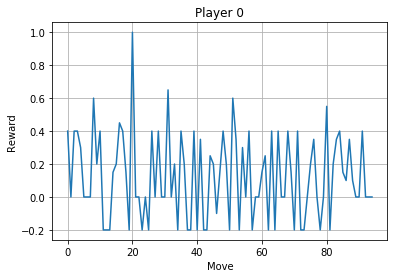

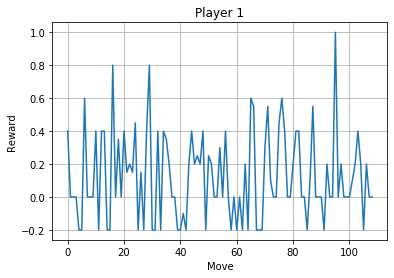

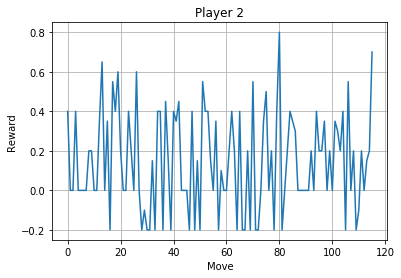

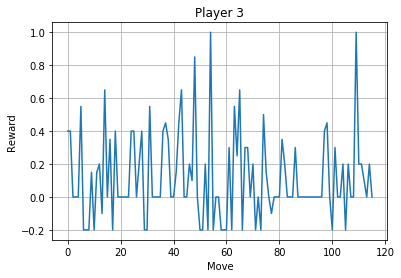

In [257]:
for i, player_rewards in enumerate(rewards):
    plt.figure()
    plt.title(f"Player {i}")
    
    plt.plot(player_rewards)
    plt.xlabel("Move")
    plt.ylabel("Reward")
    plt.grid()
    plt.show()

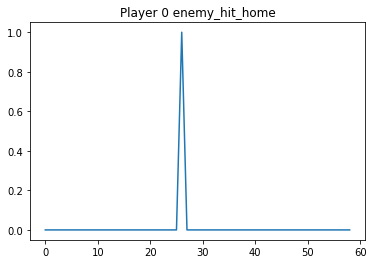

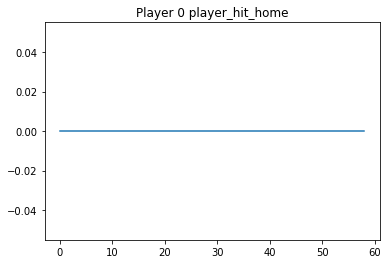

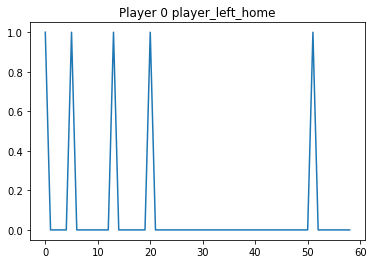

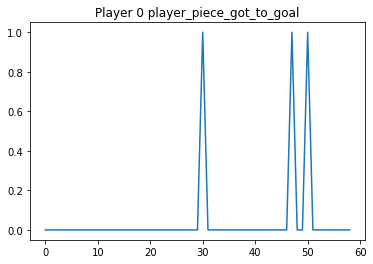

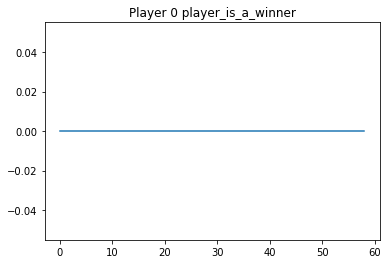

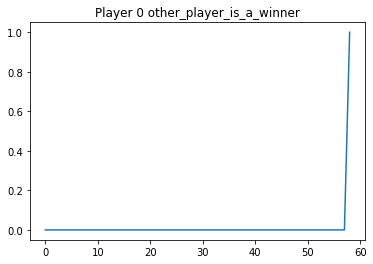

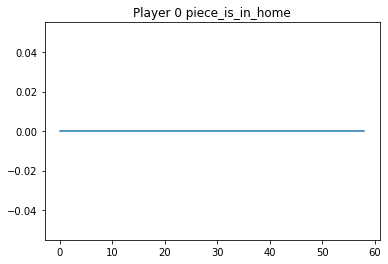

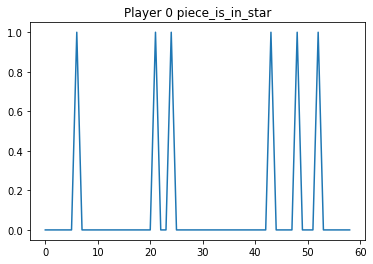

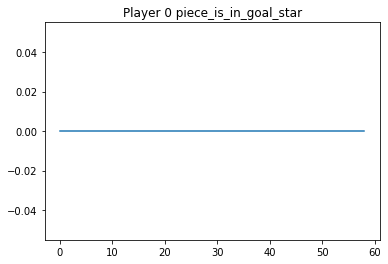

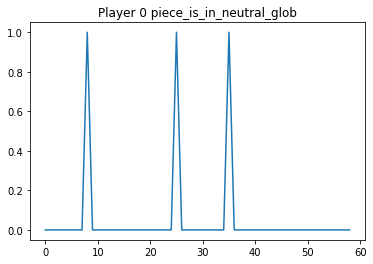

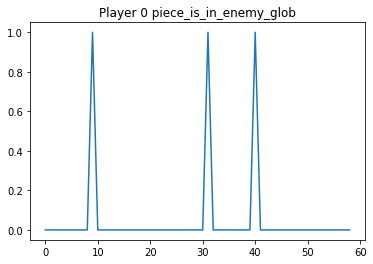

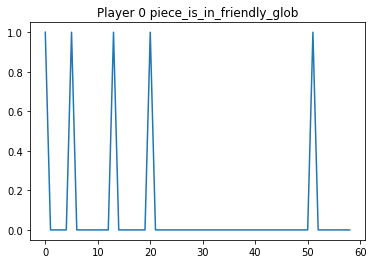

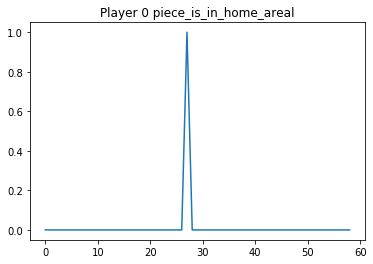

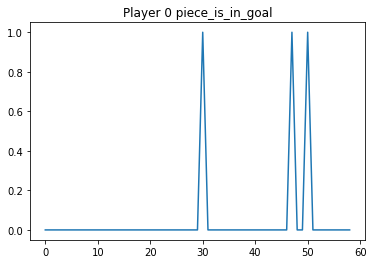

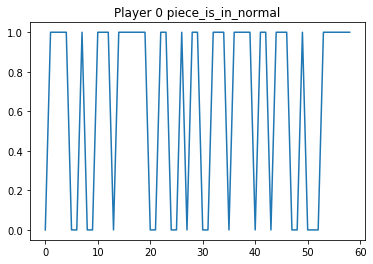

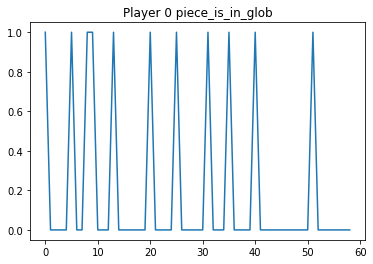

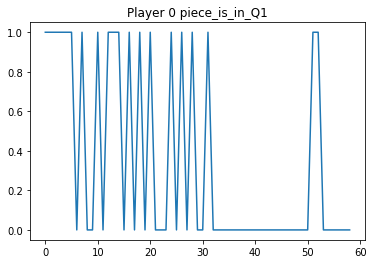

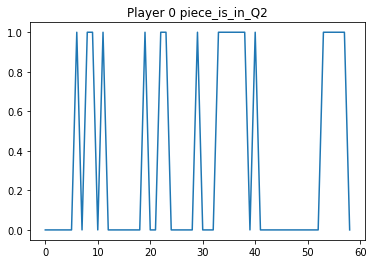

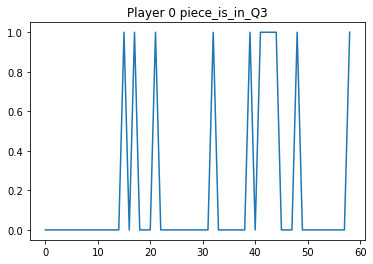

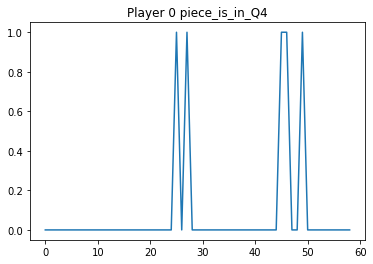

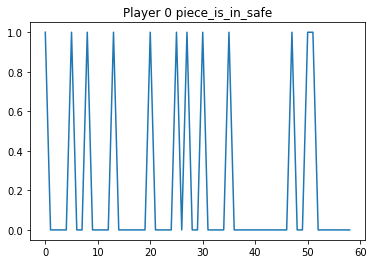

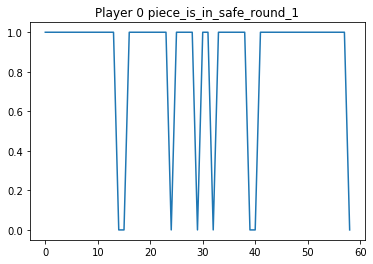

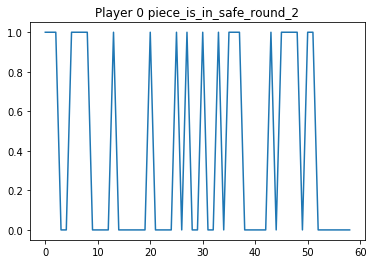

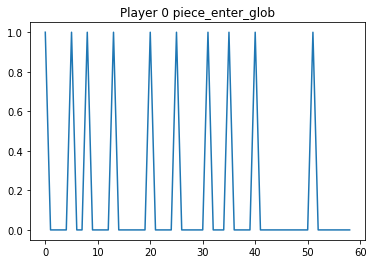

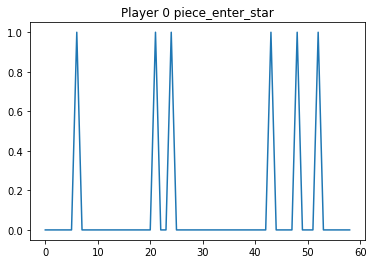

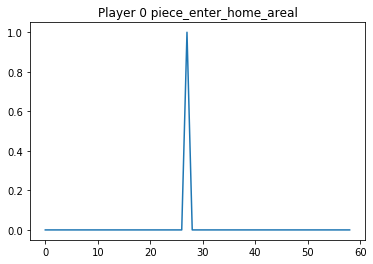

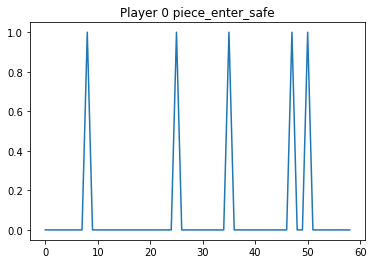

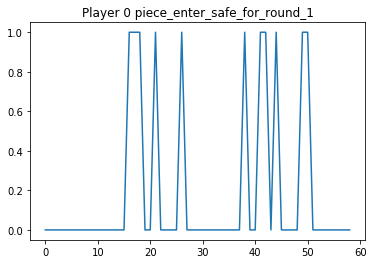

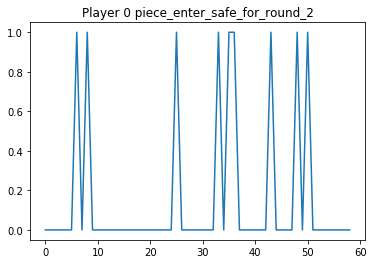

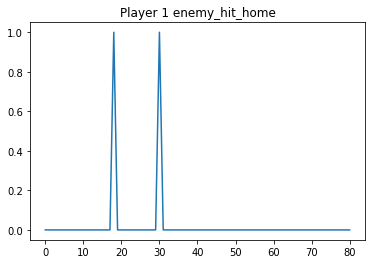

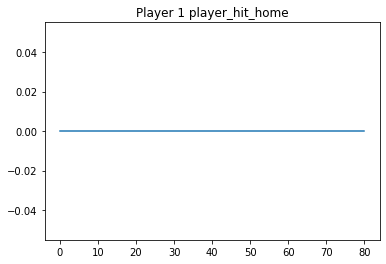

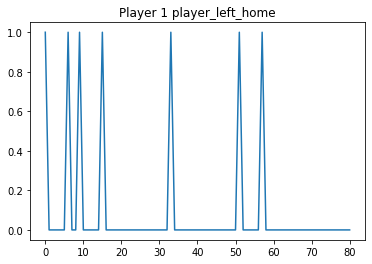

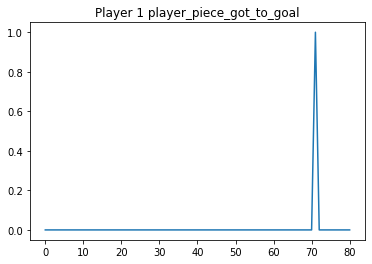

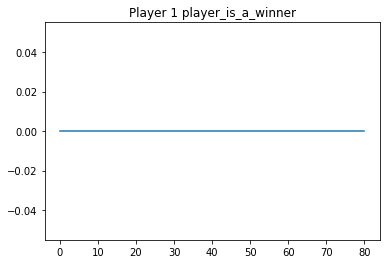

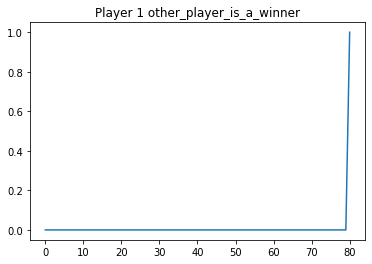

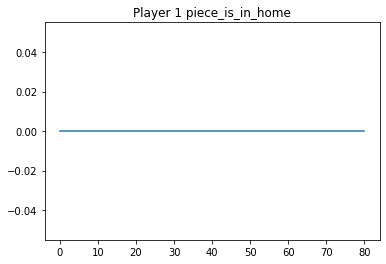

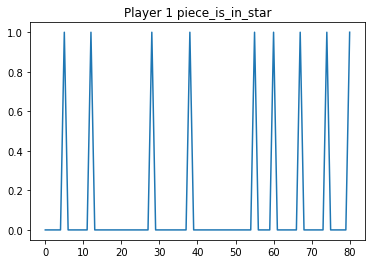

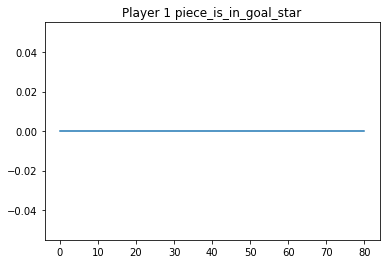

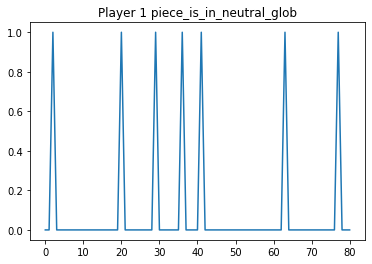

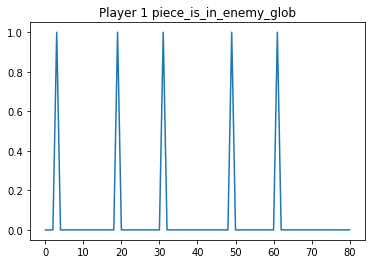

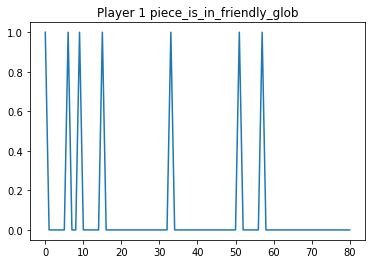

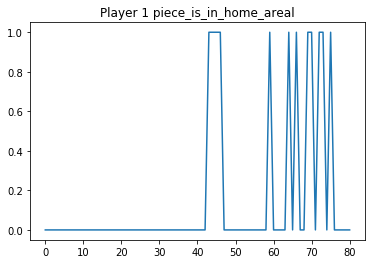

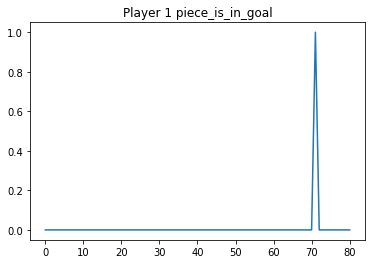

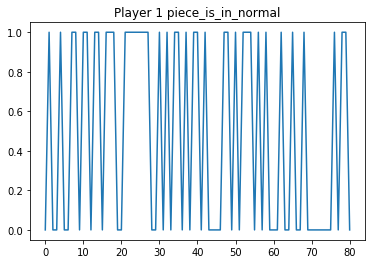

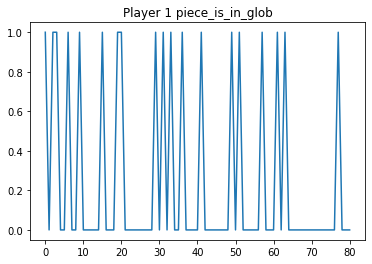

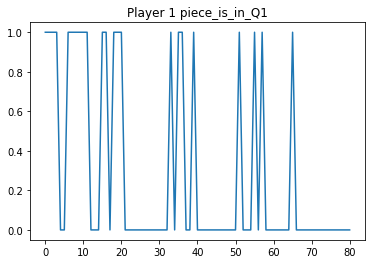

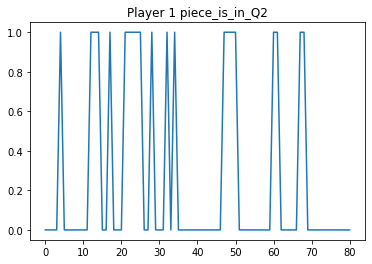

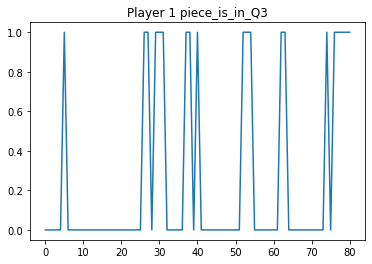

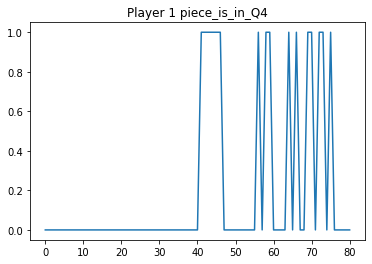

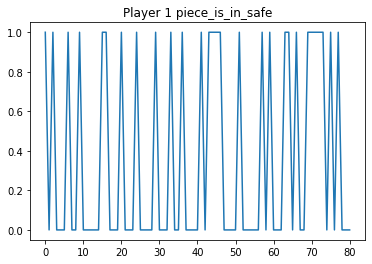

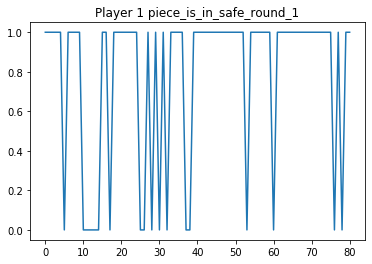

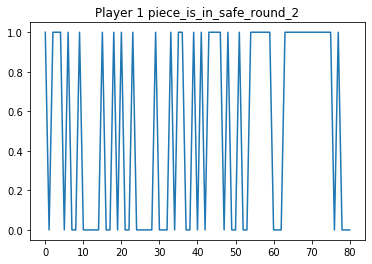

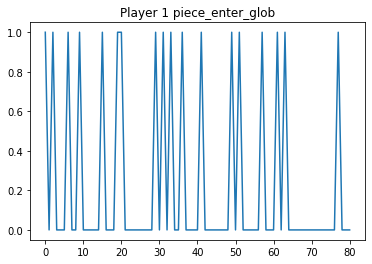

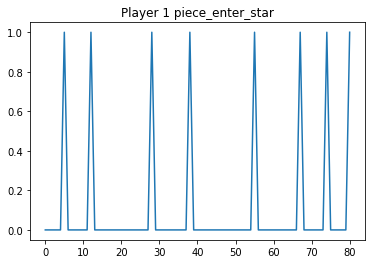

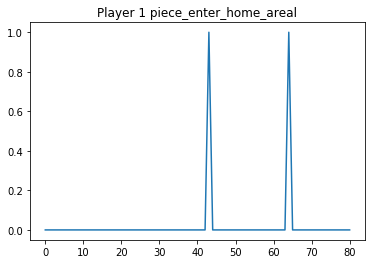

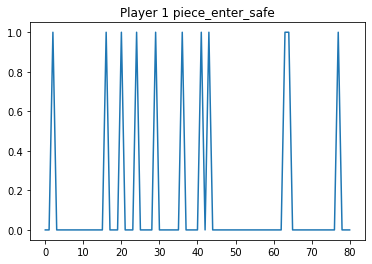

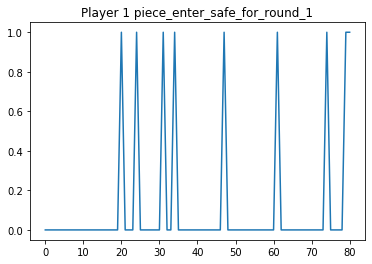

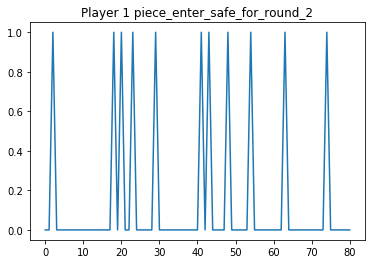

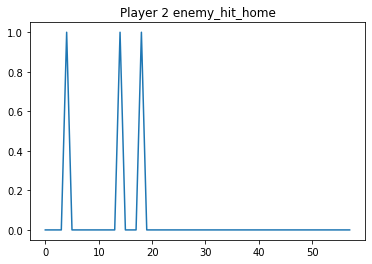

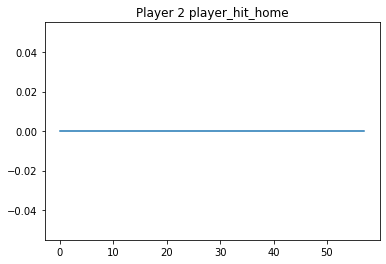

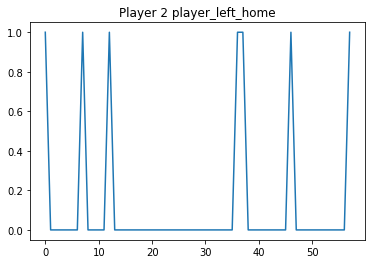

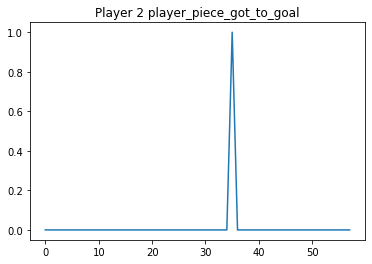

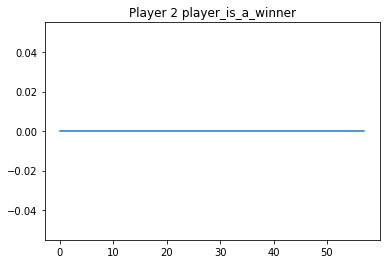

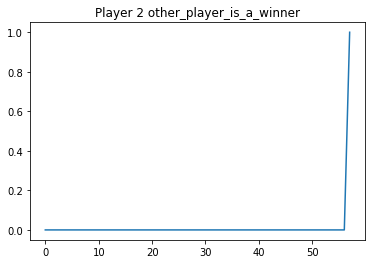

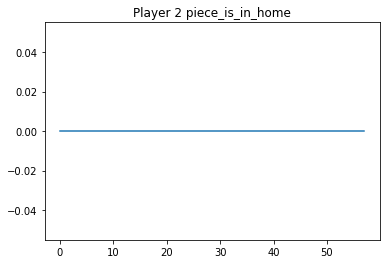

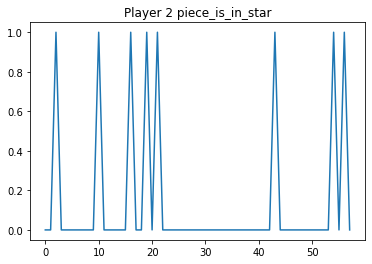

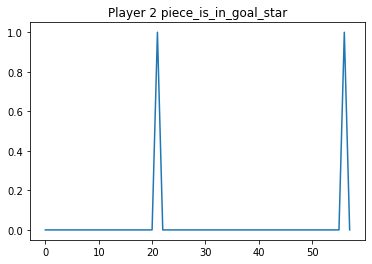

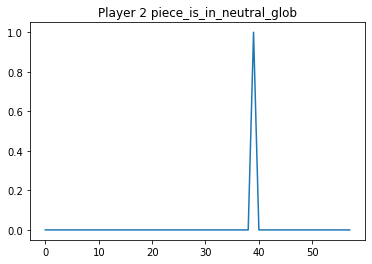

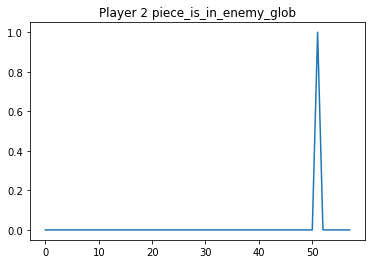

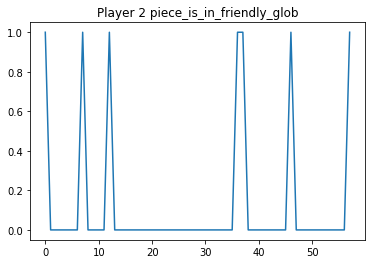

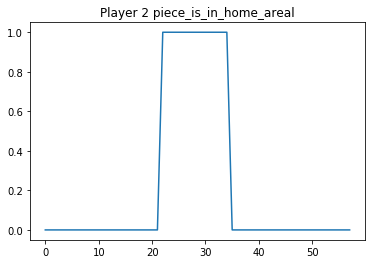

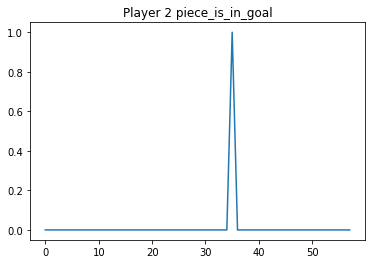

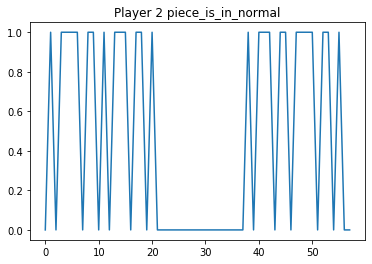

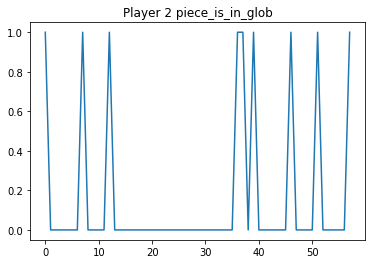

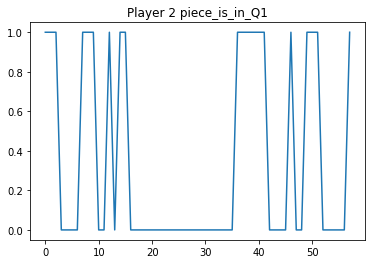

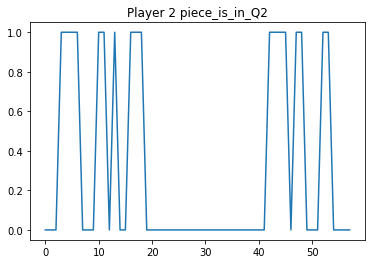

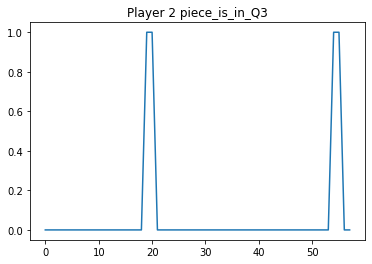

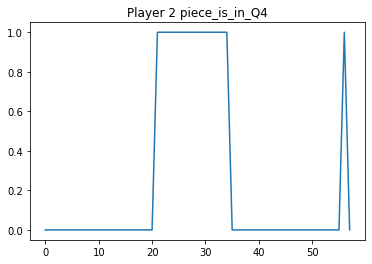

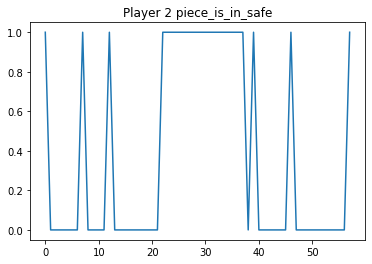

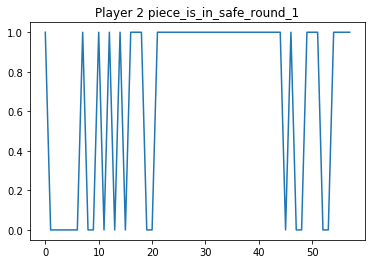

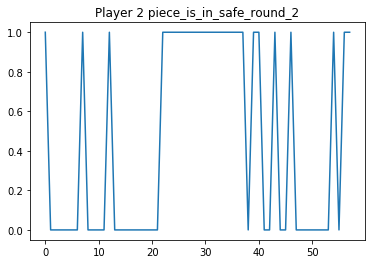

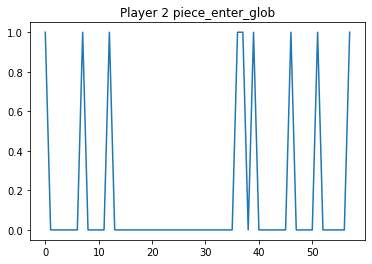

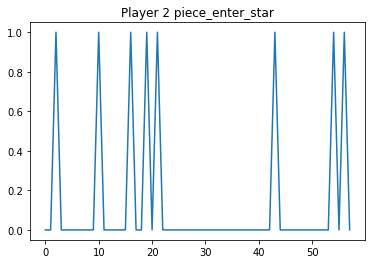

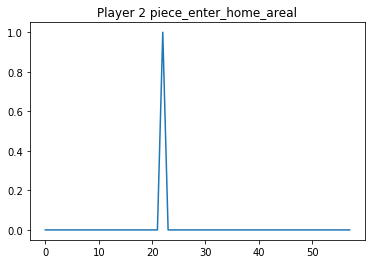

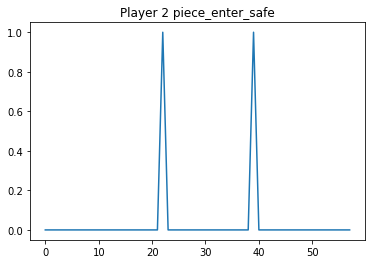

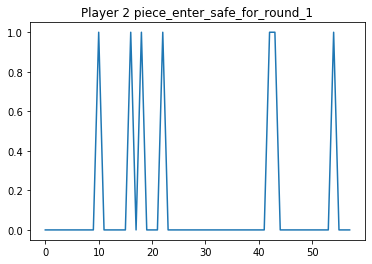

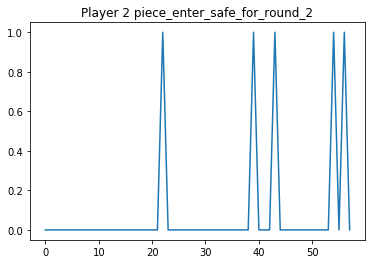

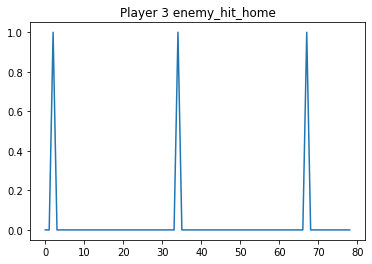

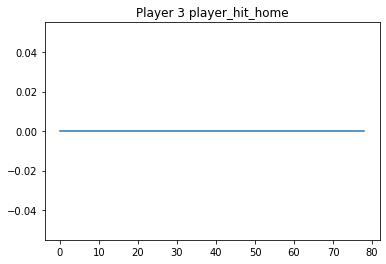

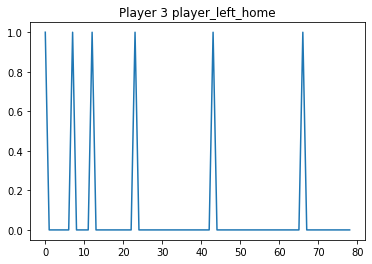

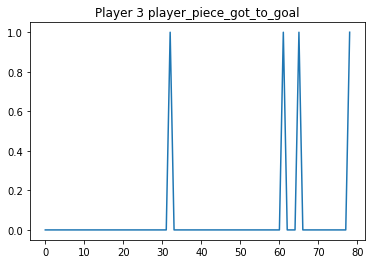

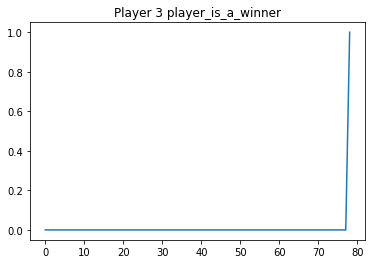

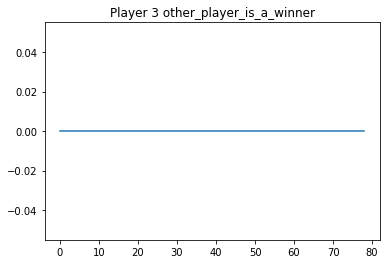

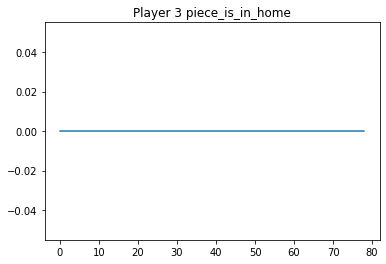

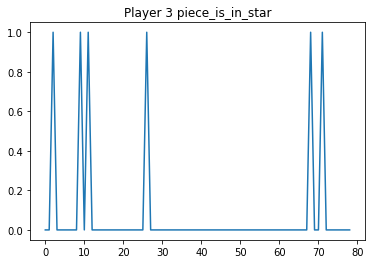

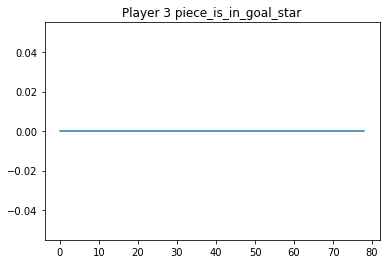

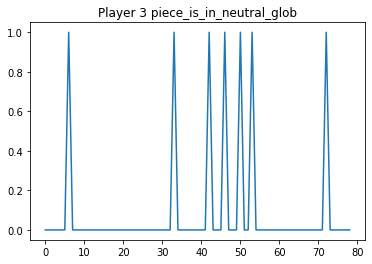

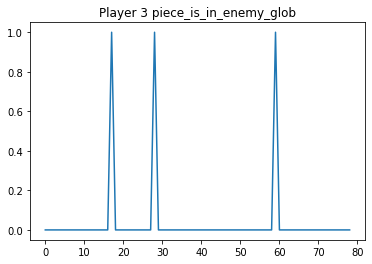

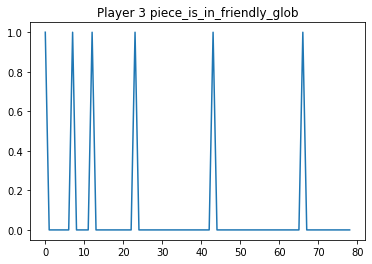

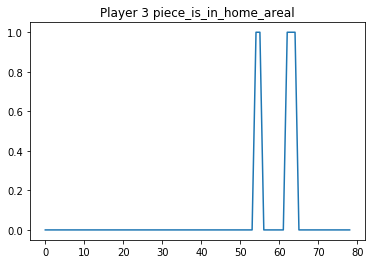

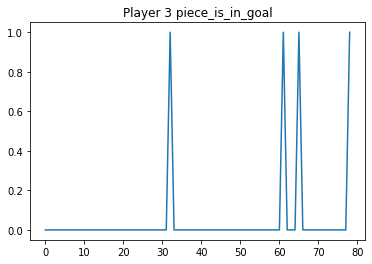

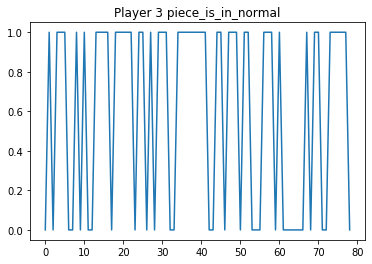

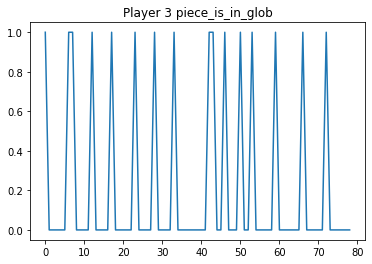

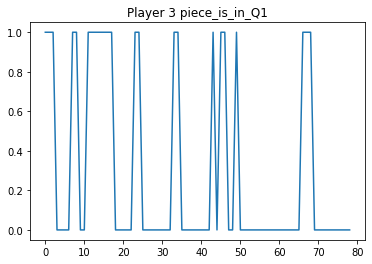

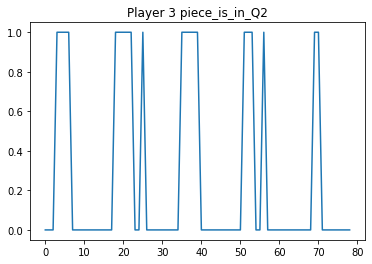

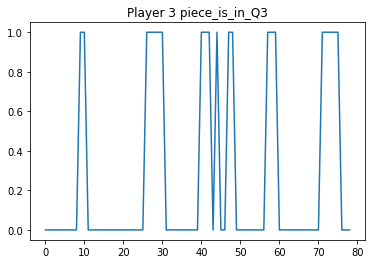

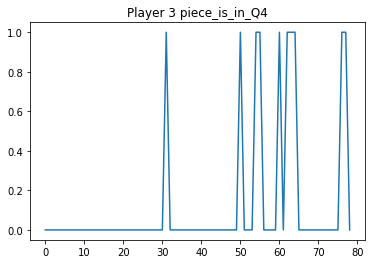

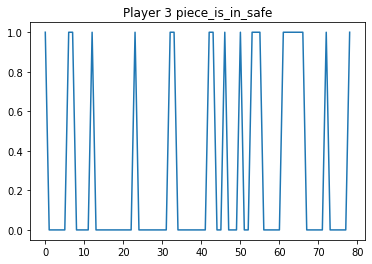

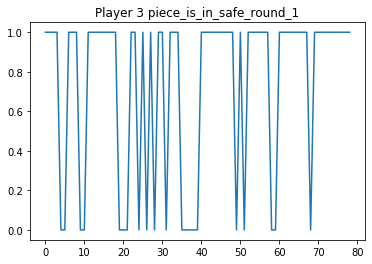

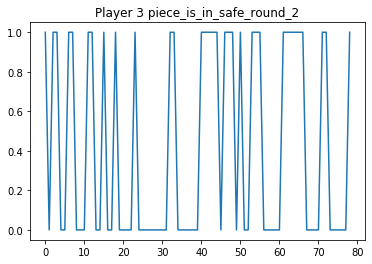

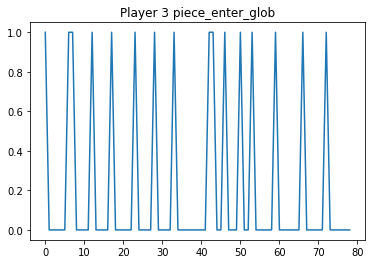

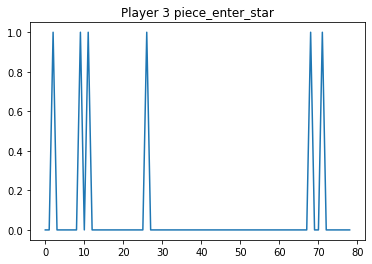

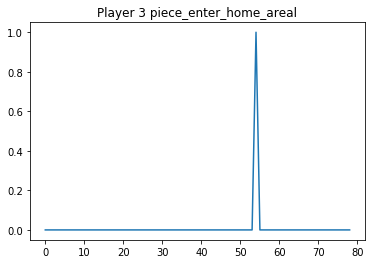

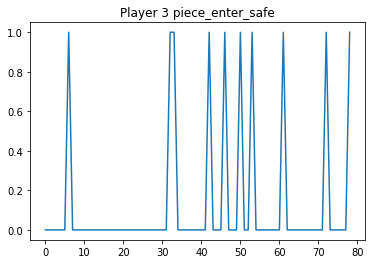

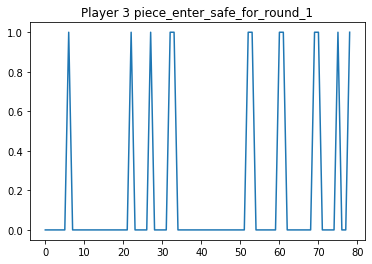

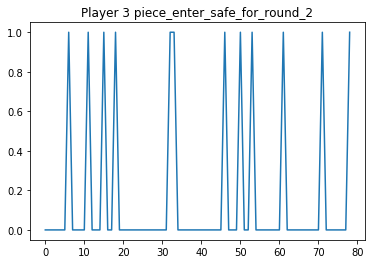

In [251]:
for i, player_events in enumerate(reward_events):
    player_events = np.array(player_events)
    
    
    for j, key in enumerate(keys):
        plt.figure()
        plt.title(f"Player {i} {key}")
        plt.plot(player_events[:,j])
        plt.show()

In [184]:
player_pieces = [13,53,4,11]
dice = 3
states = cal_state(player_pieces, enemy_pieces, dice)

In [185]:
2**len(states)

68719476736

In [176]:
d = {
}

In [186]:
len(states)

36

In [192]:
get_pos_state(player_pieces[0], player_pieces, enemy_pieces)

{'home': False,
 'star': False,
 'goal_star': False,
 'neutral_glob': False,
 'enemy_glob': False,
 'friendly_glob': False,
 'home_areal': False,
 'goal': False,
 'normal': False,
 'glob': False,
 'Q1': True,
 'Q2': False,
 'Q3': False,
 'Q4': False,
 'safe': False,
 'safe_round_1': False,
 'safe_round_2': False}